<a href="https://colab.research.google.com/github/ceciliacasarella/bertopic-modeling/blob/main/CodeChallengeNLPDynamicTopicModeling3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Dataset

In [1]:
!pip install gdown
!gdown 1YGcv-a026sMdkX_q-whqhyh1ybiH6eCI
! openssl enc -aes-256-cbc -pbkdf2 -iter 100000 -d -in datasets.tar.gz.enc | tar xz
! sudo apt-get install jq
! for i in 1 2 3 4 ; do jq length datasets/json/$i.json ; done
! for i in 1 2 3 4 ; do cat datasets/json/$i.json | jq '.[0]' ; done
! cat datasets/sq/* #print the open question for each dataset

Downloading...
From: https://drive.google.com/uc?id=1YGcv-a026sMdkX_q-whqhyh1ybiH6eCI
To: /content/datasets.tar.gz.enc
100% 215k/215k [00:00<00:00, 113MB/s]
enter AES-256-CBC decryption password:
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended

# Problem:

Unsupervised learning problem of hard clustering short text messages by topic.

# Goal:

Automatic way of labelling the topic of short open-ended survey answers.

# Possible solutions:

- Topic modeling: discovering latent topics in a collection of documents.
  -  Latent Dirichlet Allocation (LDA). LDA is a generative probabilistic model that assumes that each document is made up of a distribution of a fixed number of topics and each topic is made up of a distribution of words.
  - Clustering Embeddings: vector representation of the sentence. Google’s Universal Sentence Encoder (USE), first published by Cer et al in 2018, is a popular sentence embedding model. The USE model was trained on a variety of data, including Wikipedia, web news, web question-answer pages and discussion forums, and it performs well on sentence semantic similarity tasks.
  


## Preprocessing

In [2]:
import pandas as pd
import numpy as np
import spacy

!pip install nltk --quiet
import nltk
from nltk.corpus import stopwords
import string

In [3]:
df_json1 = pd.read_json('/content/datasets/json/3.json')
print(df_json1['text'])
print("\nFull example:" , df_json1.loc[100].text)

0                                             non saperei
1                                  attenzione all'ambiete
2                                  telegreenriscaldamento
3         sostenibilità risparmio attenzione all'ambiente
4                                             basso costo
                              ...                        
1551                                            c’è tutto
1552                  perché si vive bene e ce molta cura
1553      andrebbero descritte davvero moltissime cose...
1554                           perché potrebbe migliorare
1555    perché la qualità é sicuramente migliore rispe...
Name: text, Length: 1556, dtype: object

Full example: non saprei


#### Lowercase

In [4]:
#Lowercase
df_json1['text'] = df_json1['text'].str.lower()

In [5]:
df_json1['text'][(df_json1['text'].map(lambda x: len(x))<3)]

243      h
244      u
247      u
249      g
250      y
        ..
1474     k
1490     o
1492    ok
1531     o
1537     h
Name: text, Length: 159, dtype: object

In [6]:
df_json1 = df_json1[df_json1['text'].str.len() > 3]

In [7]:
df_json1

,id,text
0,0,non saperei
1,1,attenzione all'ambiete
2,2,telegreenriscaldamento
3,3,sostenibilità risparmio attenzione all'ambiente
4,4,basso costo
...,...,...
1551,1563,c’è tutto
1552,1564,perché si vive bene e ce molta cura
1553,1565,andrebbero descritte davvero moltissime cose...
1554,1566,perché potrebbe migliorare


## Google’s Universal Sentence Encoder (USE), first published by Cer et al in 2018

- is a popular sentence embedding model.
- encoding sentences into embedding vectors that specifically target transfer learning to other NLP tasks.



In [8]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text --quiet
import tensorflow_text

# Developed by researchers at Google, 2019
# The model is intented to be used for text classification, text clustering, semantic textural similarity retrieval, cross-lingual text retrieval, etc.

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [9]:
# Compute embeddings
def embed_text(input,model):
  return model(input)

sentence_embeddings = embed_text(list(df_json1['text']),embed)

## UMAP
- Hyperparameters:
  -  ```n_neighbors``` : balancing local vs global structure. Constraint to the size of the local neighborhood the algorithm looks when attempting to construct the manifold. A small value will force the algorithm to look into very local structure, while a bigger value takes into account the big picture.
  - ```n_components``` : dimensionality final embedding
  



In [10]:
!pip install umap --quiet
!pip install umap-learn --quiet
import matplotlib.pyplot as plt
import seaborn as sns
import umap

In [11]:
%matplotlib inline
sns.set(style='white', context='poster', rc={'figure.figsize':(12,8)})

### Inspecting effect of n_neighbors param

In [12]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(sentence_embeddings);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

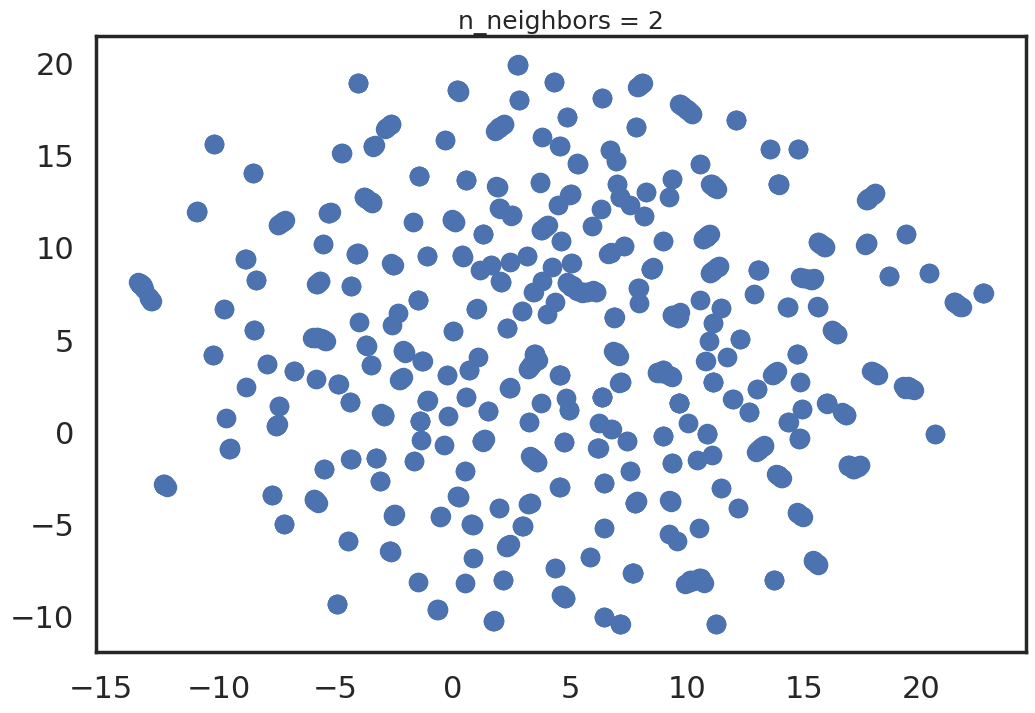

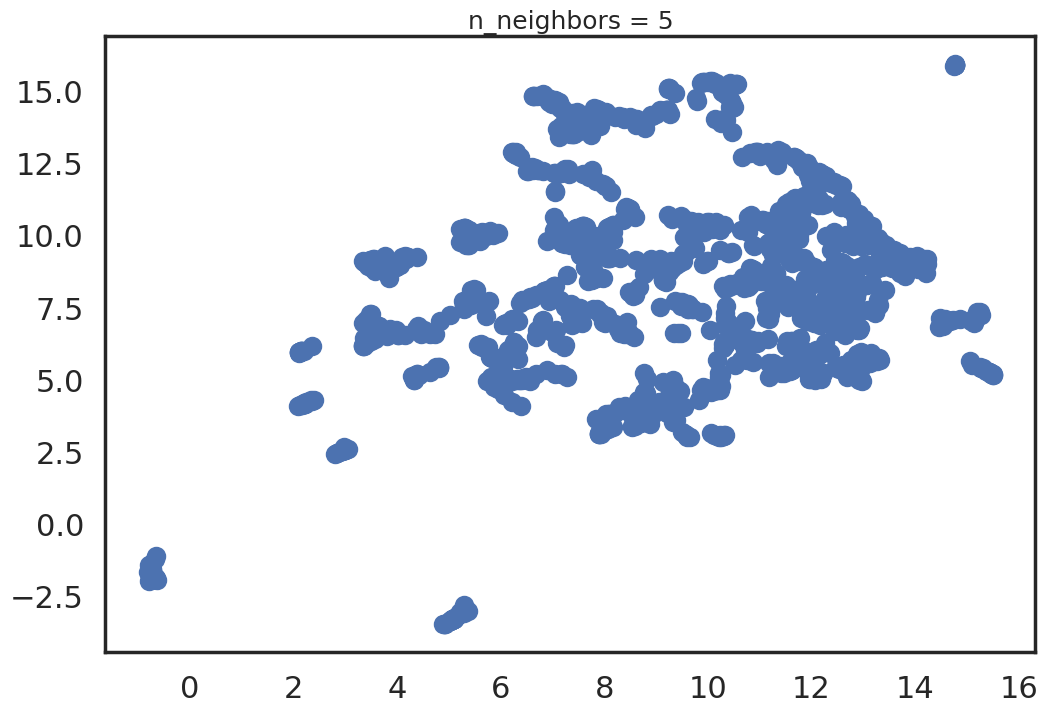

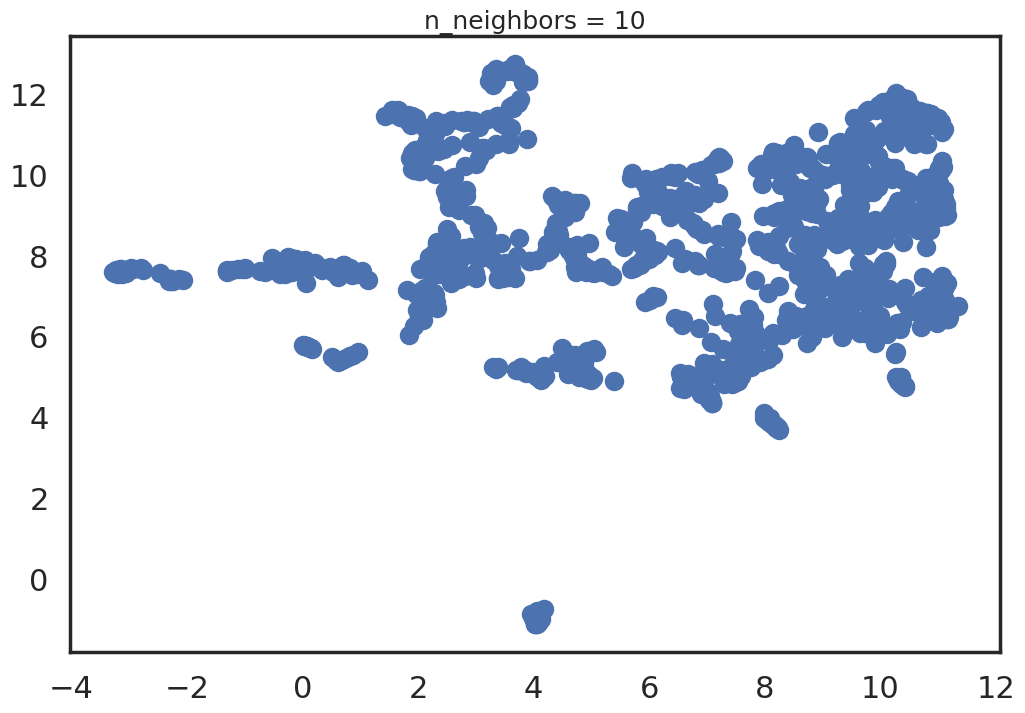

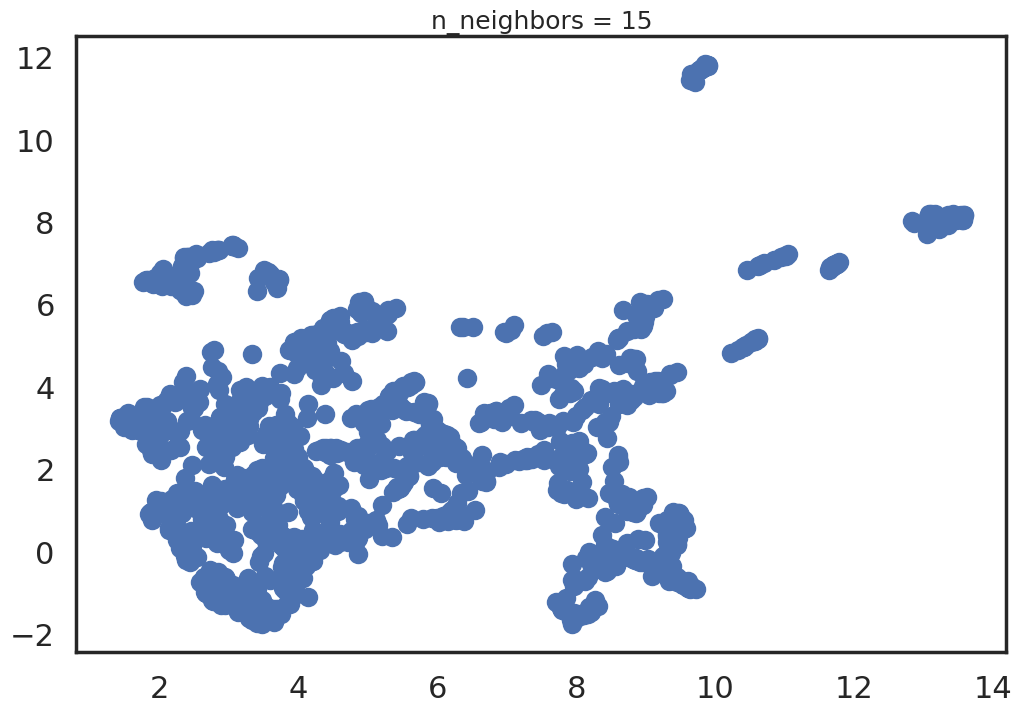

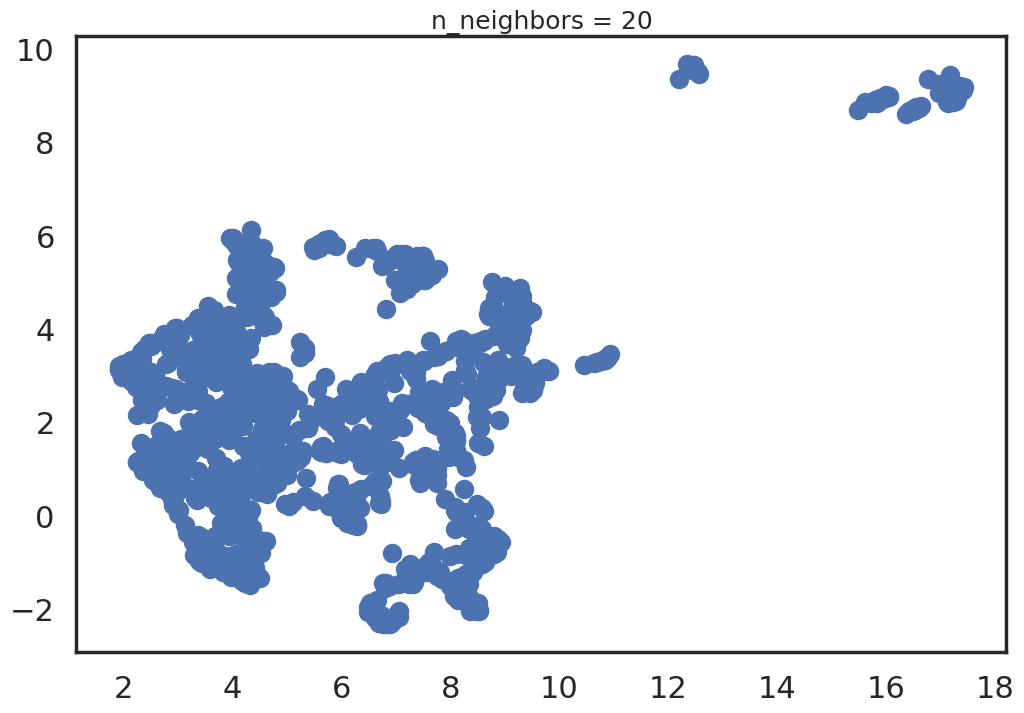

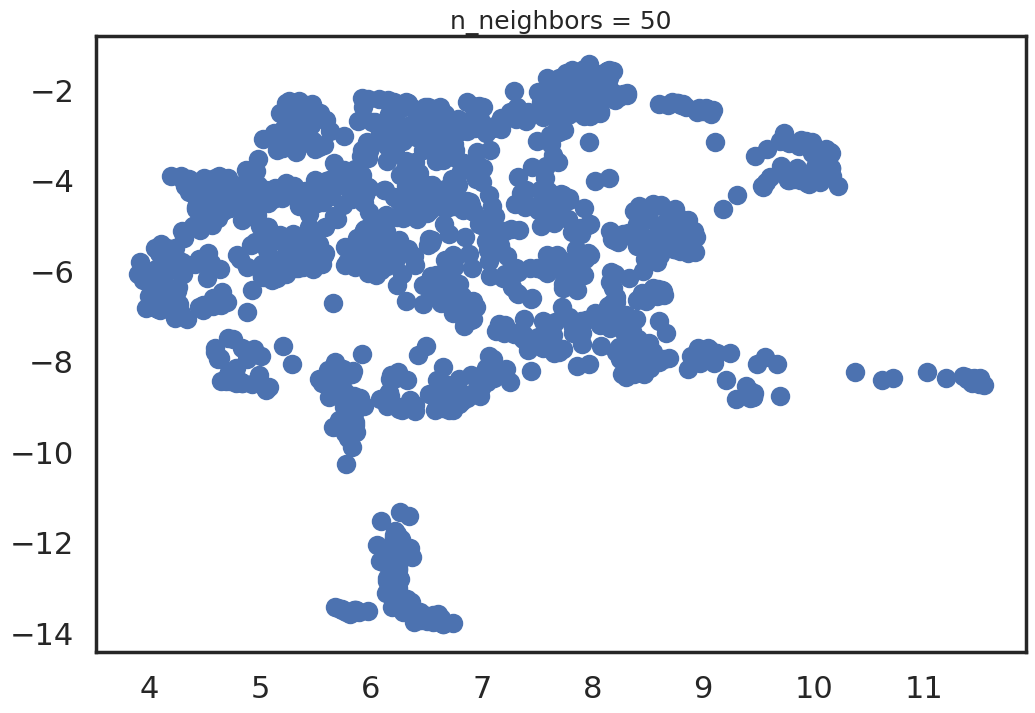

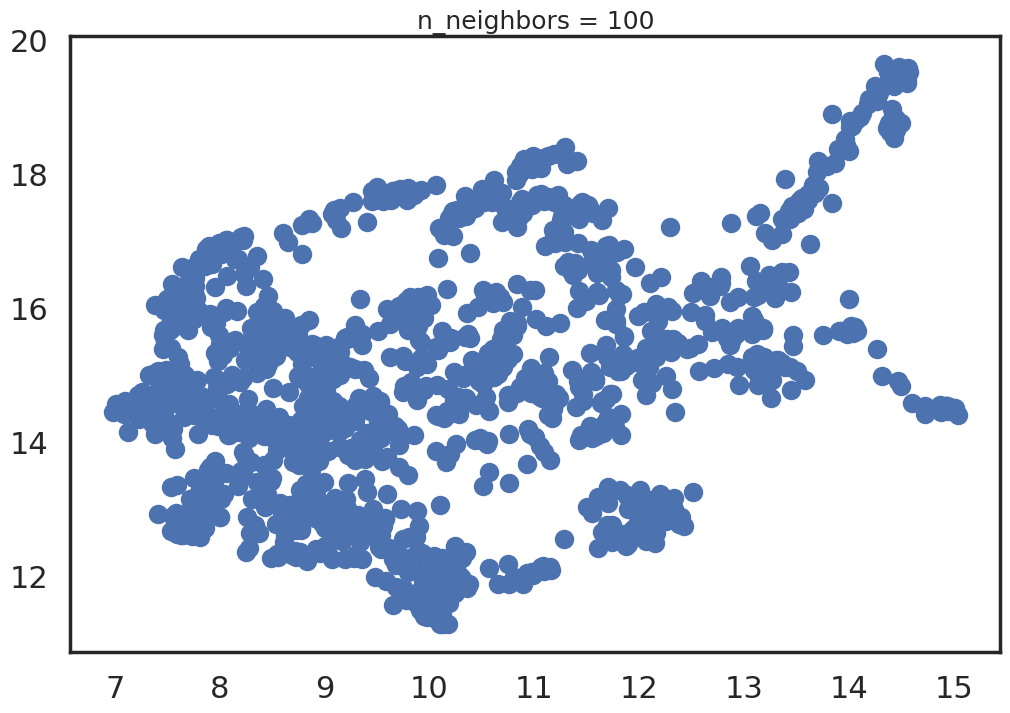

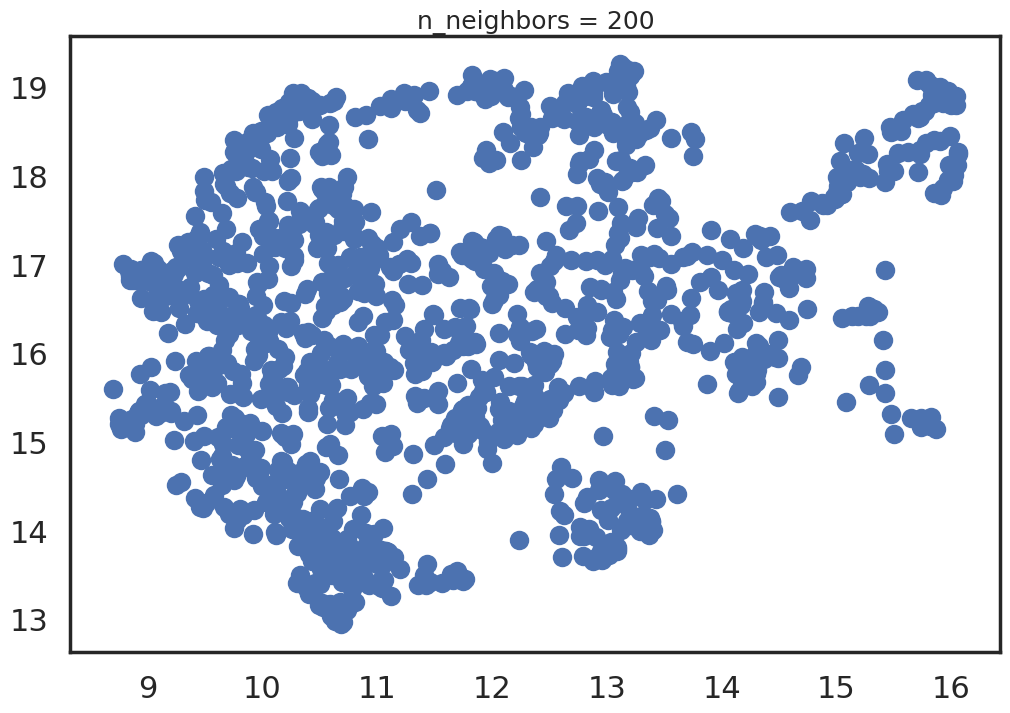

In [13]:
for n in (2, 5, 10, 15, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

## HDBSCAN

At a high level, we can simplify the process of density-based clustering into these steps:

1. Estimate the densities
2. Pick regions of high density
3. Combine points in these selected regions


**core distance** is the distance of a point to its K-th nearest neighbor.
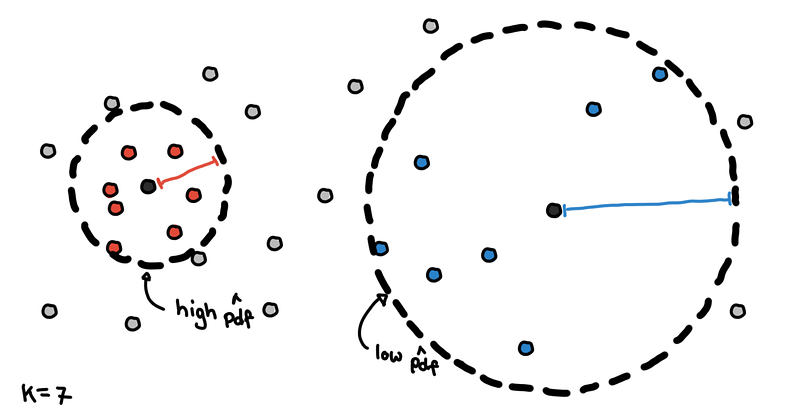

Points in denser regions would have smaller core distances while points in sparser regions would have larger core distances. Core distance is what makes these methods “density-based”.

HDBSCAN first builds a hierarchy to figure out which peaks end up merging together and in what order, and then for each cluster it asks, is it better to keep this cluster or split it up into its subclusters?


https://pberba.github.io/stats/2020/07/08/intro-hdbscan/

Hyperparameter:
- ```min_cluster_size``` : smallest grouping you want consider as cluster.




In [14]:
!pip install hdbscan --quiet
import hdbscan

In [87]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      random_state = 42):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """

    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors,
                                n_components=n_components,
                                metric='cosine',
                                min_dist=0,
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean',
                               cluster_selection_method='eom',approx_min_span_tree=False).fit(umap_embeddings)

    umap_embeddings = np.array(umap_embeddings, dtype=np.double)
    #print("The calculated DBCV metric for this solution is: ", hdbscan.validity_index(umap_embeddings,clusters.labels_))

    return clusters, hdbscan.validity_index(umap_embeddings,clusters.labels_)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


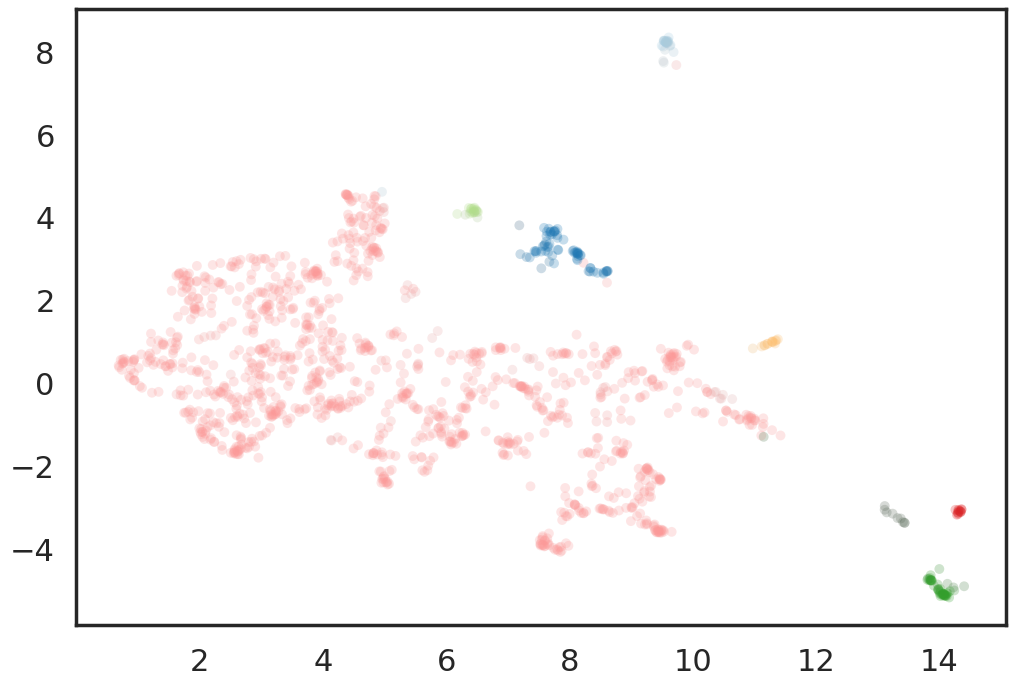

In [16]:
def print_generated_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      random_state = None) :

    clusters, _ = generate_clusters(message_embeddings,n_neighbors,n_components,min_cluster_size)
    u = (umap.UMAP(n_neighbors=n_neighbors, n_components=2, metric='cosine').fit_transform(message_embeddings))

    color_palette = sns.color_palette('Paired', 100)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusters.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                            zip(cluster_colors, clusters.probabilities_)]
    plt.scatter(u[:,0], u[:,1],s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

    return clusters

clusters = print_generated_clusters(sentence_embeddings,15,20,10)

In [17]:
df_json1['hdbscan_possible_labels'] = clusters.labels_

In [18]:
df_json1[df_json1['hdbscan_possible_labels'] == 12]

,id,text,hdbscan_possible_labels


As for clustering, the HDBSCAN algorithm is used because of its ability to handle noise.
However, it has poor performance on clustering high-dimensional data. Because vectors resulting from word embedding are high-dimensional, therefore dimension reduction by UMAP is done on the vectors before feeding it to HDBSCAN.

# Validation

One of the most challenging aspects of clustering is validation, which is the objective and quantitative assessment of
clustering results.

- **Density-based clustering** algorithms seek partitions
with high density areas of points (clusters, not necessarily
globular) separated by low density areas, possibly containing noise objects.
Considering such a model we can expect a good density-based clustering solution to have clusters in which the
lowest density area inside each cluster is still denser than
the highest density area surrounding clusters. **density-based clustering should be defined
by means of densities rather than by distances**.
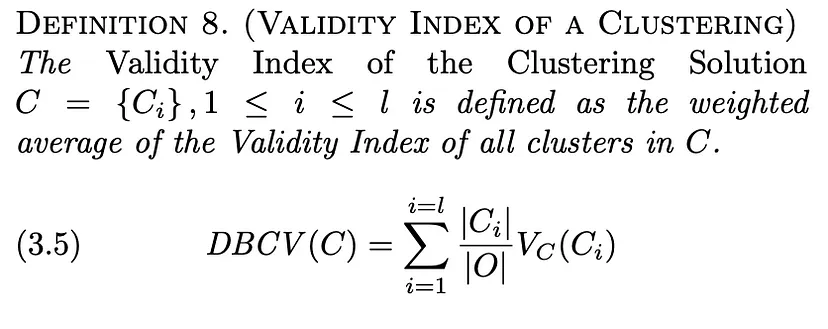

> Cost = percent of dataset with < 5% cluster label confidence, Subject to: min < num_clusters < max

Leveraging the useful probabilities_ HDBSCAN attribute, which from the documentation is:

> The strength with which each sample is a member of its assigned cluster. Noise points have probability zero; points in clusters have values assigned proportional to the degree that they persist as part of the cluster.

In [19]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan

    """

    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)

    return label_count, cost

## Hyperopt

In [20]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, space_eval

def objective(params, embeddings, label_lower, label_upper, penalty):
    """
    Objective function for hyperopt to minimize, which incorporates constraints
    on the number of clusters we want to identify
    """

    clusters,dbcv = generate_clusters(embeddings,
                                 n_neighbors = params['n_neighbors'],
                                 n_components = params['n_components'],
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])

    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)

    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = penalty
    else:
        penalty = 0

    loss = cost + penalty

    return {'loss': loss, 'label_count': label_count,'dbvc_score':dbcv, 'status':STATUS_OK}

In [21]:
def bayesian_search(embeddings, space, label_lower, label_upper, penalty, max_evals=100):
    """
    Perform bayseian search on hyperopt hyperparameter space to minimize objective function
    """

    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, label_lower=label_lower, label_upper=label_upper, penalty= penalty)
    best = fmin(fmin_objective,
                space = space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    best_params = space_eval(space, best)
    print ('Best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    print (f"dbvc score: {trials.best_trial['result']['dbvc_score']}")


    best_clusters = generate_clusters(embeddings,
                                      n_neighbors = best_params['n_neighbors'],
                                      n_components = best_params['n_components'],
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])

    return best_params, best_clusters, trials

In [22]:
bopt_space = {
    "n_neighbors": hp.choice(('n_neighbors'),range(5,100)),
    "n_components": hp.choice(('n_components'),range(5,100)),
    "min_cluster_size": hp.choice(('min_cluster_size'),range(5,50)),
    "random_state":None,
}

label_lower = 5
label_upper = 10
max_evals=50
penalty= 0.3
#best_params, best_clusters, trials = bayesian_search(sentence_embeddings, bopt_space, label_lower, label_upper, penalty, max_evals)

## MlFlow

In [23]:
!pip install mlflow --quiet
import mlflow
from mlflow.tracking import MlflowClient

In [24]:
def create_ml_flow_experiment(client, experiment_name, experiment_tags):
        """
        Create a new mlflow experiment

        :client: MlFlow Client
        :experiment_name: Provide an Experiment unique name.
        :experiment_tags: Provide searchable tags that define characteristics of the Runs that will be in this Experiment.

        :return: new eval function.
        """

        # Create the Experiment, providing a unique name
        experiment = client.create_experiment(
            name=experiment_name, tags=experiment_tags
        )

        return experiment

In [26]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is short-text hard clustering evaluation using umap and hdbscan."
)

# Tags
experiment_tags = {
    "project_name": "short-text-clustering",
    "dataset_description": "teleriscaldamento-experiment",
    "mlflow.note.content": experiment_description,
}

tracking_client = MlflowClient()
experiment_name = "TELE-Riscaldamento-Models-2"
create_ml_flow_experiment(tracking_client, experiment_name, experiment_tags)

'174533885245900897'

In [27]:
# Use search_experiments() to search on the project_name tag key
vars(tracking_client.search_experiments(
    filter_string="tags.`project_name` = 'short-text-clustering'"
)[0])

{'_experiment_id': '174533885245900897',
 '_name': 'TELE-Riscaldamento-Models-2',
 '_artifact_location': 'file:///content/mlruns/174533885245900897',
 '_lifecycle_stage': 'active',
 '_tags': {'dataset_description': 'teleriscaldamento-experiment',
  'project_name': 'short-text-clustering',
  'mlflow.note.content': 'This is short-text hard clustering evaluation using umap and hdbscan.'},
 '_creation_time': 1699452779240,
 '_last_update_time': 1699452779240}

In [97]:
import mlflow
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, space_eval
import numpy as np

np.random.seed(42)


def clustering_eval_mlflow(
        experiment_name, run_name, embeddings, label_lower, label_upper, penalty, max_evals = 100,
    ):

        """
        Create a new eval function

        :experiment_id: Experiment unique name for the training run.
        :run_name: Define a run name for this iteration of training.
        :label_lower: Lower bound for K number of clusters.
        :label_upper: Upper bound for K number of clusters.
        :max_evals: Number of evals to train the model.


        :return: new eval function.
        """

        mlflow.set_experiment(experiment_name)


        def objective_f(params, embeddings, label_lower, label_upper, penalty):
            """
            Objective function for hyperopt to minimize, which incorporates constraints
            on the number of clusters we want to identify
            """

            clusters, dbcv = generate_clusters(embeddings,
                                        n_neighbors = params['n_neighbors'],
                                        n_components = params['n_components'],
                                        min_cluster_size = params['min_cluster_size'],
                                        random_state = params['random_state'])

            label_count, cost = score_clusters(clusters, prob_threshold = 0.05)

            # % penalty on the cost function if outside the desired range of groups
            if (label_count < label_lower) | (label_count > label_upper):
                penalty = penalty
            else:
                penalty = 0

            loss = cost + penalty

            metrics = {'loss': loss, 'label_count': label_count,'dbvc_score':dbcv}

            mlflow.end_run()
            # Initiate the MLflow run context
            with mlflow.start_run(run_name=run_name) as run:
                # Log the parameters used for the model fit
                mlflow.log_params(params)
                # Log the error metrics that were calculated during validation
                mlflow.log_metrics(metrics)

            return {'loss': loss, 'label_count': label_count,'dbvc_score':dbcv, 'status':STATUS_OK}


        bopt_space = {
            "n_neighbors": hp.choice(('n_neighbors'),range(5,100)),
            "n_components": hp.choice(('n_components'),range(5,100)),
            "min_cluster_size": hp.choice(('min_cluster_size'),range(5,500)),
            "random_state":42,
        }

        fmin_objective = partial(objective_f, embeddings=embeddings, label_lower=label_lower, label_upper=label_upper, penalty=penalty)
        best = fmin(fmin_objective,
                    space = bopt_space,
                    algo=tpe.suggest,
                    max_evals=max_evals)

        best_params = space_eval(bopt_space, best)
        mlflow.set_tag("best params", str(best_params))
        return best_params

label_lower = 5
label_upper = 12
max_evals = 100
penalty= 0.3
run_name = "teleriscaldamento_umap_hdbscan_test_2"
best_params = clustering_eval_mlflow(experiment_name, run_name, sentence_embeddings, label_lower, label_upper, penalty, max_evals=max_evals)

100%|██████████| 100/100 [21:34<00:00, 12.94s/trial, best loss: 0.0]


In [98]:
best_params

{'min_cluster_size': 18,
 'n_components': 15,
 'n_neighbors': 18,
 'random_state': 42}

In [ ]:
# Use search_experiments() to search on the project_name tag key
experiment_id = vars(tracking_client.search_experiments(
    filter_string="tags.`project_name` = 'short-text-clustering'"
)[0])['_experiment_id']
runs = MlflowClient().search_runs(experiment_ids=experiment_id)

for r in runs:
    if r.data.metrics and r.data.metrics["loss"] ==  0.597550432276657:
        best_run = r

In [ ]:
best_run

## BertTopic

In [32]:
# Installation
!pip install bertopic --quiet

In [104]:
# Step1 : Embedding
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
# Step2 : Dimensionality Reduction
umap_model = umap.UMAP(n_neighbors=best_params['n_neighbors'], n_components=best_params['n_components'], metric='cosine', min_dist=0.0, random_state=42)
# Step3 : Clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=best_params['min_cluster_size'], metric='euclidean', cluster_selection_method='eom', approx_min_span_tree=False, prediction_data=True)

## Topic Representation

Topic representation is the key for interpreting the topics.

One often underestimated component of BERTopic is the CountVectorizer and c-TF-IDF calculation. Together, they are responsible for creating the topic representations and luckily can be quite flexible in parameter tuning.

CountVectorizer -> word-level tokenization


In [111]:
from nltk.corpus import stopwords
nltk.download('stopwords')

from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired

italian_stopwords = stopwords.words("italian")
#Step4 : CountVectorizer
#CountVectorizer and c-TF-IDF calculation are responsible for creating the topic representations
from sklearn.feature_extraction.text import CountVectorizer
# Fine-tune topic representations after training BERTopic
vectorizer_model = CountVectorizer(stop_words=italian_stopwords, ngram_range=(1, 4), min_df=2)
ctfidf_model = ClassTfidfTransformer()
# Topic representations
representation_model = KeyBERTInspired()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
from bertopic import BERTopic
topic_model = BERTopic(
                       embedding_model=embed,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       vectorizer_model=vectorizer_model,
                       #ctfidf_model=ctfidf_model,
                       representation_model=representation_model)
topics, probs = topic_model.fit_transform(list(df_json1['text']))

In [113]:
topic_model.visualize_barchart()

In [114]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,331,-1_parchi_parco_spazio verde_giardini,"[parchi, parco, spazio verde, giardini, spazi ...",[nel mio quartiere curano abbastanza bene il v...
1,0,156,0_risparmio_ambiente_efficace_riduzione inquin...,"[risparmio, ambiente, efficace, riduzione inqu...","[risparmio e convenienza, praticità, risparmi..."
2,1,98,1_pochi spazi verdi_spazi verdi pochi_pochi sp...,"[pochi spazi verdi, spazi verdi pochi, pochi s...","[pochi spazi verdi disponibili, ci sono pochi ..."
3,2,91,2_perchè molto_perchè molto buona_perchè_perche,"[perchè molto, perchè molto buona, perchè, per...","[perchè è buona, perchè non è eccezionale, per..."
4,3,70,3_saprei_nn_no_credo,"[saprei, nn, no, credo, saprei cosa, altro sap...","[non saprei, non saprei, non so non saprei]"
5,4,68,4_potrebbe fare meglio_potrebbe fare piu potre...,"[potrebbe fare meglio, potrebbe fare piu potre...","[si potrebbe fare di meglio, si potrebbe fare ..."
6,5,67,5_spazi verdi città_verdi città_spazi verdi lu...,"[spazi verdi città, verdi città, spazi verdi l...",[perché nella mia città gli spazi verdi sono m...
7,6,65,6_molto verde_abbastanza verde_tanto verde_verde,"[molto verde, abbastanza verde, tanto verde, v...","[molto verde, sono circondato dal verde, verde]"
8,7,63,7_abbastanza buona_molto buona_buona abbastanz...,"[abbastanza buona, molto buona, buona abbastan...","[non è molto buona, si abbastanza buona, abba..."
9,8,58,8_vivo paese_paese vivo_campagna_vivo zona,"[vivo paese, paese vivo, campagna, vivo zona, ...","[vivo in campagna, vivo in campagna..., vivo i..."


In [38]:
topic_model.visualize_documents(list(df_json1['text']))

In [39]:
topic_model.visualize_topics()

In [40]:
topic_model.visualize_heatmap()